<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-deep-learning/blob/main/5.4.%20Build%20my%20ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


In [ ]:
import torch.nn as nn

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation)

In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [ ]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, inplanes, planes, stride=1, downsample=None,):
    super(BasicBlock, self).__init__()
    self.conv1=conv3x3(inplanes,planes,stride)
    self.bn1=nn.BatchNorm2d(planes)
    self.relu=nn.ReLU(inplace=True)
    self.conv2=conv3x3(planes,planes)
    self.bn2=nn.BatchNorm2d(planes)
    self.downsample=downsample
    self.stride=stride

    if(stride!=1 or inplanes!=planes*self.expansion):
      self.downsample=nn.Sequential(
        nn.Conv2d(inplanes,planes*self.expansion,kernel_size=1,stride=stride,bias=False),
        nn.BatchNorm2d(planes*self.expansion),
      )

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)

    # Downsample:feature Map size/2 || Channel increase
    if (self.downsample is not None):
      residual = self.downsample(x)
    print("out= ", out.shape, "residual= ", residual.shape)
    out+=residual
    out=self.relu(out)
    return out

In [ ]:
class MyResNet(nn.Module):
  def __init__(self, block, layers, num_classes=2):
    super(MyResNet, self).__init__()
    self.inplanes = 64
    self.dilation = 1
    self.conv1=nn.Conv2d(3,self.inplanes,kernel_size=7,stride=2, padding=3, bias=False)
    self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2, padding=1)
    self.layer1=self._make_layer(block,64,layers[0])
    self.layer2=self._make_layer(block,128,layers[1],stride=2)
    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(128*block.expansion,num_classes)
    self.linear=nn.Linear(128*block.expansion,num_classes)

  def _make_layer(self, block, planes, blocks, stride=1):
    layers=[]
    layers.append(block(self.inplanes,planes,stride))
    self.inplanes=planes*block.expansion

    for i in range(1,blocks):
      layers.append(block(self.inplanes,planes))
    return nn.Sequential(*layers)

  def forward(self, x):
    x=self.conv1(x)
    x=self.maxpool(x)
    x=self.layer1(x)
    x=self.layer2(x)
    x=self.avgpool(x)
    x=torch.flatten(x, 1)
    x=self.fc(x)
    return x

In [ ]:
model=MyResNet(BasicBlock,[1,1]).to(device)
print(model)

MyResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, 

#Upload an image file to Colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cat.jpg to cat (1).jpg


In [ ]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

cat.jpg


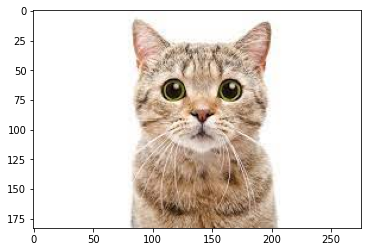

In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread(fname)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
from torchvision import transforms
transformer = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

In [ ]:
from PIL import Image
PILImg= Image.fromarray(image.astype('uint8')).convert('RGB')
PILImg = transformer(PILImg)
PILImg.shape

torch.Size([3, 224, 224])

In [ ]:
imageTensor = torch.unsqueeze(PILImg, 0)
imageTensor.shape

torch.Size([1, 3, 224, 224])

#Send input image to my ResNet step by step

In [ ]:
out1=model.conv1(imageTensor.to(device))
print(out1.shape)

torch.Size([1, 64, 112, 112])


In [ ]:
out2=model.maxpool(out1)
print(out2.shape)

torch.Size([1, 64, 56, 56])


In [ ]:
out3=model.layer1(out2)

out=  torch.Size([1, 64, 56, 56]) residual=  torch.Size([1, 64, 56, 56])


In [ ]:
out4 = model.layer2(out3)

out=  torch.Size([1, 128, 28, 28]) residual=  torch.Size([1, 128, 28, 28])


In [ ]:
out5= model.avgpool(out4)
print(out5.shape)

torch.Size([1, 128, 1, 1])


In [ ]:
out6=torch.flatten(out5,1)
print(out6.shape)

torch.Size([1, 128])


In [ ]:
out7 = model.fc(out6)
print(out7)

tensor([[-0.0661, -0.1440]], device='cuda:0', grad_fn=<AddmmBackward>)


#Do forward processing in one time

In [ ]:
y = model(imageTensor.to(device))
print(y)

out=  torch.Size([1, 64, 56, 56]) residual=  torch.Size([1, 64, 56, 56])
out=  torch.Size([1, 128, 28, 28]) residual=  torch.Size([1, 128, 28, 28])
tensor([[-0.0661, -0.1440]], device='cuda:0', grad_fn=<AddmmBackward>)
